In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycaret.regression import *

### pycaret 설치 가이드 (Python 3.8 기준)

1. pip install pycaret==3.1.0

2. pip install joblib==1.3

In [2]:
dg_df = pd.read_csv('./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/Demographics.csv')
dg_df.head(16)

,ID,Gender,HbA1c
0,13,MALE,5.7
1,1,FEMALE,5.5
2,3,FEMALE,5.9
3,4,FEMALE,6.4
4,5,FEMALE,5.7
5,2,MALE,5.6
6,6,FEMALE,5.8
7,7,FEMALE,5.3
8,8,FEMALE,5.6
9,10,FEMALE,6.0


In [3]:
df = pd.read_csv(r'./features.csv', sep='\t', encoding='utf-8')

In [4]:
df = df.dropna().drop(columns=['Unnamed: 0']).reset_index(drop=True)

In [5]:
df.isna().sum()

calories2hr       0
protein2hr        0
sugar2hr          0
carbs2hr          0
calories8hr       0
                 ..
HbA1c             0
Biological Sex    0
CVSD              0
WakeTime          0
label             0
Length: 78, dtype: int64

In [6]:
df['Biological Sex'] = df['Biological Sex'].map({'FEMALE': 0, 'MALE': 1})

In [7]:
df['label'] = df['label'].map({'PersLow': 0, 'PersNorm': 1, 'PersHigh':2})

### 상관관계 Matrix Heat map

In [8]:
corrdf = df.drop(columns=['datetime']).corr()

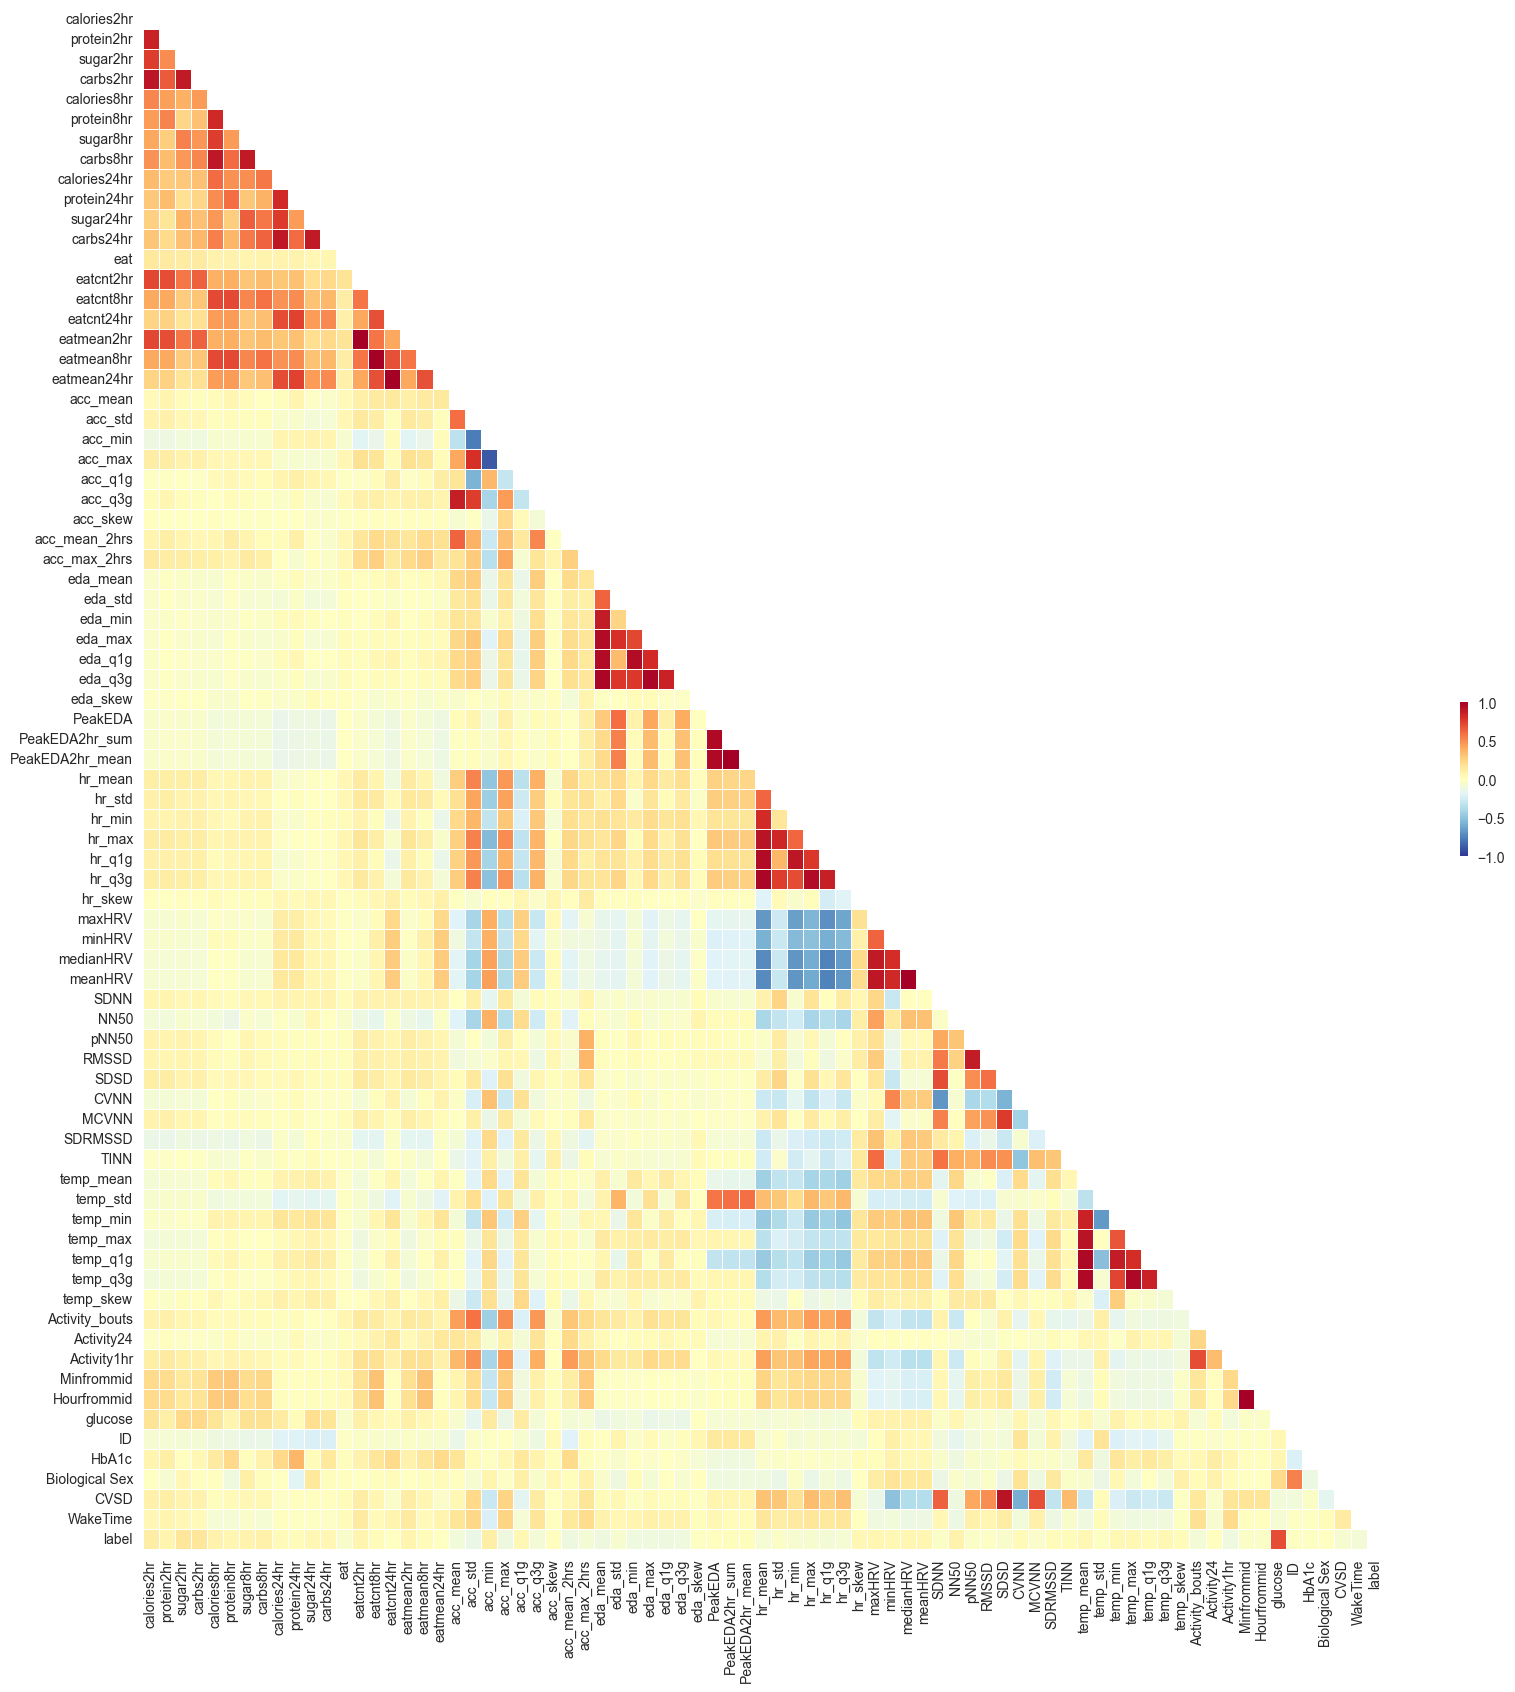

In [9]:
import seaborn as sns

# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(20,20) )

mask = np.zeros_like(corrdf)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(corrdf, 
            cmap = 'RdYlBu_r', 
            annot = False,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .1},# 컬러바 크기 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

### Leave-one-person-out cross validation : 최적의 MSE 평균을 내는 모델을 이용한 간질 포도당 예측

def ModelCompareLOOCV(data, ids, outcomevar, dropcols, idcolumn):
    LOOCV_O = str(ids)
    data[idcolumn] = data[idcolumn].apply(str)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]

    print(f'LOOCV_O : {LOOCV_O}')
   
    # Test data - the person left out of training
    data_test = data_cv.drop(columns=dropcols)
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable
    
    # Train data - all other people in dataframe
    data_train = data_filtered.drop(columns=dropcols)
    X_train = data_train.drop(columns=[outcomevar])
    
    feature_list = list(X_train.columns)
    X_train= np.array(X_train)
    y_train = np.array(data_train[outcomevar]) #Outcome variable here

    ## PYCARET
    exp = setup(data_train, test_data = data_test, target='glucose')
    comp = compare_models()

    return comp

def loocvLGBMRegressor(data, idcolumn, outcomevar, dropcols=[], numestimators=1000):
    # Make list of all ID's in idcolumn
    IDlist = list(set(data[idcolumn].astype(str))) # list(data[idcolumn]) -> list(set(data[idcolumn]))
    print(f'IDlist : {IDlist}')
    drop = [idcolumn]
    drop = drop + dropcols
    
    # Initialize empty lists and dataframe 
    errors = []
    rmse = []
    mape = []
    
    for i in IDlist:
        comp = ModelCompareLOOCV(data, i, outcomevar, drop, idcolumn, numestimators)
        #TODO : comp로부터 각 모델 별 MAPE, MSE를 저장

        idt = str(i)
        print('...' + idt + ' processing complete.')

    #TODO : 위의 for문에서 저장한 각 모델 별 MAPE, MSE의 평균을 계산
    
    
    #TODO : RMSE의 평균이 가장 낮은 모델을 출력하기

    return 

In [10]:
import numpy as np
import pandas as pd
from pycaret.regression import setup, compare_models, predict_model

def ModelCompareLOOCV(data, ids, outcomevar, dropcols, idcolumn):
    LOOCV_O = ids #str(ids)
    data[idcolumn] = data[idcolumn] #.apply(str)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]

    print(f'LOOCV_O : {LOOCV_O}')
   
    # Test data - the person left out of training
    data_test = data_cv.drop(columns=dropcols)
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable
    
    # Train data - all other people in dataframe
    data_train = data_filtered.drop(columns=dropcols)
    X_train = data_train.drop(columns=[outcomevar])
    
    feature_list = list(X_train.columns)
    X_train= np.array(X_train)
    y_train = np.array(data_train[outcomevar]) #Outcome variable here

    ## PYCARET
    exp = setup(data_train, 
                test_data=data_test, 
                target=outcomevar, 
                feature_selection = True,
                feature_selection_method = 'classic', # or 'boruta' 
                n_features_to_select=15,
                pca=True,
                #feature_selection_estimator= ''
                verbose=False, 
                session_id = 123, #random state
                use_gpu = False)
    comp = compare_models(cross_validation=False, n_select=20, verbose=True)#, errors = 'raise')

    return comp, exp, data_test, y_test


def loocvModelCompareRegressor(data, idcolumn, outcomevar, dropcols=[]):
    IDlist = list(set(data[idcolumn].astype(int)))
    print(f'IDlist : {IDlist}')
    drop = [] #[idcolumn] to []
    drop = drop + dropcols
    
    model_errors = {}

    for i in IDlist:
        comp, exp, data_test, y_test = ModelCompareLOOCV(data, i, outcomevar, drop, idcolumn)
        
        for model in comp:
            model_name = model.__class__.__name__
            if model_name not in model_errors:
                model_errors[model_name] = {'MAPE': [], 'RMSE': []}
            
            # Predict on the test set
            predictions = predict_model(model, data=data_test, verbose=False)
            y_pred = predictions['prediction_label'] if 'prediction_label' in predictions.columns else predictions[outcomevar]
            
            # Calculate errors
            mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
            mse = np.mean((y_test - y_pred) ** 2)
            rmse = np.sqrt(mse)

            model_errors[model_name]['MAPE'].append(mape)
            model_errors[model_name]['RMSE'].append(rmse)

    model_avg_errors = {model: {metric: np.mean(values) for metric, values in metrics.items()} for model, metrics in model_errors.items()}
    
    print(model_avg_errors)

    # Find the model with the lowest average RMSE
    best_model = min(model_avg_errors, key=lambda model: model_avg_errors[model]['RMSE'])
    best_model_errors = model_avg_errors[best_model]

    print(f'Best model: {best_model}')
    print(f'Errors: {best_model_errors}')

    return best_model, best_model_errors

In [11]:
best_model, best_model_errors = loocvModelCompareRegressor(data=df, idcolumn='ID', outcomevar='glucose', dropcols=['label', 'datetime'])

IDlist : [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16]
LOOCV_O : 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 27789, number of used features: 75
[LightGBM] [Info] Start training from score 116.775739


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,12.9153,284.5610,16.8689,-0.1750,0.1569,0.1265,1.1400
ridge,Ridge Regression,14.4065,324.6143,18.0171,-0.3404,0.1681,0.1447,0.7000
lr,Linear Regression,14.4214,325.1777,18.0327,-0.3428,0.1682,0.1449,0.7800
lar,Least Angle Regression,14.4214,325.1777,18.0327,-0.3428,0.1682,0.1449,0.7700
br,Bayesian Ridge,14.6572,332.5423,18.2357,-0.3732,0.1701,0.1475,0.7600
dummy,Dummy Regressor,15.5389,332.6340,18.2383,-0.3736,0.1710,0.1558,0.8100
llar,Lasso Least Angle Regression,15.5389,332.6340,18.2383,-0.3736,0.1710,0.1558,0.8100
lasso,Lasso Regression,15.9373,374.5071,19.3522,-0.5465,0.1799,0.1614,0.7300
en,Elastic Net,15.9498,375.6751,19.3823,-0.5513,0.1801,0.1615,0.7700
omp,Orthogonal Matching Pursuit,16.6458,376.0607,19.3923,-0.5529,0.1809,0.1680,0.7600


LOOCV_O : 2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 28231, number of used features: 75
[LightGBM] [Info] Start training from score 115.164571


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,18.4425,558.4708,23.6320,-0.3177,0.1772,0.1355,0.7400
lasso,Lasso Regression,19.5086,597.1908,24.4375,-0.4090,0.1843,0.1453,0.7200
en,Elastic Net,19.5235,597.3465,24.4407,-0.4094,0.1843,0.1455,0.8800
ada,AdaBoost Regressor,19.8178,606.5697,24.6286,-0.4312,0.1858,0.1469,3.4100
dummy,Dummy Regressor,19.6927,638.6856,25.2722,-0.5069,0.1895,0.1417,0.7500
llar,Lasso Least Angle Regression,19.6927,638.6856,25.2722,-0.5069,0.1895,0.1417,0.7400
huber,Huber Regressor,21.0629,684.8595,26.1698,-0.6159,0.1986,0.1550,1.2100
br,Bayesian Ridge,21.0202,685.0772,26.1740,-0.6164,0.1990,0.1541,0.7900
lar,Least Angle Regression,21.0819,689.1092,26.2509,-0.6259,0.1997,0.1545,0.8200
lr,Linear Regression,21.0819,689.1093,26.2509,-0.6259,0.1997,0.1545,0.7400


LOOCV_O : 3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 28047, number of used features: 75
[LightGBM] [Info] Start training from score 116.685635


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,12.9579,302.1083,17.3813,-0.0137,0.1551,0.1250,0.7300
br,Bayesian Ridge,12.9702,302.3559,17.3884,-0.0145,0.1552,0.1251,0.7300
par,Passive Aggressive Regressor,11.5399,303.3625,17.4173,-0.0179,0.1505,0.1041,1.1000
lr,Linear Regression,13.0056,303.7420,17.4282,-0.0192,0.1555,0.1254,0.7300
lar,Least Angle Regression,13.0056,303.7420,17.4282,-0.0192,0.1555,0.1254,0.7400
en,Elastic Net,13.3356,312.0381,17.6646,-0.0470,0.1591,0.1305,0.7300
lasso,Lasso Regression,13.3702,313.2034,17.6976,-0.0509,0.1595,0.1310,0.7100
et,Extra Trees Regressor,12.9464,322.2917,17.9525,-0.0814,0.1614,0.1275,1.8000
gbr,Gradient Boosting Regressor,13.3935,323.0962,17.9749,-0.0841,0.1616,0.1316,11.8100
lightgbm,Light Gradient Boosting Machine,13.5964,343.8570,18.5434,-0.1538,0.1657,0.1328,0.9200


LOOCV_O : 4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 28187, number of used features: 75
[LightGBM] [Info] Start training from score 116.271650


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
llar,Lasso Least Angle Regression,13.7625,335.7013,18.3222,-0.0367,0.1607,0.1286,0.7200
dummy,Dummy Regressor,13.7625,335.7014,18.3222,-0.0367,0.1607,0.1286,0.7500
omp,Orthogonal Matching Pursuit,13.7535,335.8467,18.3261,-0.0371,0.1590,0.1260,0.7200
lasso,Lasso Regression,13.9542,345.0285,18.5749,-0.0655,0.1608,0.1262,0.7200
en,Elastic Net,13.9843,346.6654,18.6190,-0.0705,0.1612,0.1264,0.7100
huber,Huber Regressor,14.0933,346.6716,18.6191,-0.0705,0.1593,0.1240,1.2000
br,Bayesian Ridge,15.2991,403.7428,20.0934,-0.2468,0.1774,0.1474,0.7100
ridge,Ridge Regression,15.4723,410.4124,20.2586,-0.2674,0.1789,0.1493,0.7200
lar,Least Angle Regression,15.4987,410.7963,20.2681,-0.2685,0.1790,0.1496,0.7200
lr,Linear Regression,15.4987,410.7963,20.2681,-0.2685,0.1790,0.1496,0.7300


LOOCV_O : 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 27793, number of used features: 75
[LightGBM] [Info] Start training from score 117.064333


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
par,Passive Aggressive Regressor,9.8202,168.3205,12.9738,0.1255,0.1279,0.0965,1.0700
et,Extra Trees Regressor,12.3863,239.3666,15.4715,-0.2436,0.1488,0.1295,1.9800
gbr,Gradient Boosting Regressor,12.3309,244.0177,15.6211,-0.2678,0.1503,0.1297,11.8800
huber,Huber Regressor,12.4435,256.9066,16.0283,-0.3348,0.1517,0.1277,1.2700
lightgbm,Light Gradient Boosting Machine,12.5969,258.5302,16.0789,-0.3432,0.1533,0.1316,0.9600
lar,Least Angle Regression,13.1791,271.6461,16.4817,-0.4113,0.1587,0.1388,0.7900
lr,Linear Regression,13.1791,271.6461,16.4817,-0.4113,0.1587,0.1388,0.7600
ridge,Ridge Regression,13.2237,273.3920,16.5346,-0.4204,0.1592,0.1393,0.7200
br,Bayesian Ridge,13.2468,274.1226,16.5566,-0.4242,0.1594,0.1396,0.7600
en,Elastic Net,13.6567,287.2680,16.9490,-0.4925,0.1630,0.1440,0.7300


LOOCV_O : 6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 27503, number of used features: 75
[LightGBM] [Info] Start training from score 115.289823


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,20.0138,826.8058,28.7542,0.0539,0.2040,0.1465,1.8600
ada,AdaBoost Regressor,21.7553,829.1541,28.7950,0.0512,0.2109,0.1712,2.7300
ridge,Ridge Regression,20.1172,846.7119,29.0983,0.0311,0.2080,0.1468,0.7900
lr,Linear Regression,20.1807,846.9144,29.1018,0.0309,0.2082,0.1475,0.8200
lar,Least Angle Regression,20.1807,846.9147,29.1018,0.0309,0.2082,0.1475,0.7800
br,Bayesian Ridge,20.1354,848.2680,29.1250,0.0293,0.2082,0.1469,0.9100
lasso,Lasso Regression,20.2269,862.4827,29.3681,0.0131,0.2100,0.1468,0.8000
en,Elastic Net,20.2334,863.9915,29.3937,0.0113,0.2102,0.1468,0.8000
omp,Orthogonal Matching Pursuit,20.9555,887.3311,29.7881,-0.0154,0.2127,0.1550,0.8100
gbr,Gradient Boosting Regressor,20.6645,906.6495,30.1106,-0.0375,0.2146,0.1493,12.2900


LOOCV_O : 8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 27829, number of used features: 75
[LightGBM] [Info] Start training from score 116.237199


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,10.6040,193.4563,13.9089,0.1978,0.1196,0.0947,0.7100
br,Bayesian Ridge,10.6157,193.5548,13.9124,0.1974,0.1197,0.0949,0.7300
huber,Huber Regressor,10.2675,194.1606,13.9342,0.1949,0.1179,0.0885,1.2000
lr,Linear Regression,10.6277,196.0878,14.0031,0.1869,0.1203,0.0948,0.7900
lar,Least Angle Regression,10.6277,196.0878,14.0031,0.1869,0.1203,0.0948,0.7800
en,Elastic Net,11.0404,200.4785,14.1590,0.1687,0.1227,0.1000,0.7500
lasso,Lasso Regression,11.0482,200.8150,14.1709,0.1673,0.1228,0.1001,0.7600
gbr,Gradient Boosting Regressor,11.3865,216.9520,14.7293,0.1004,0.1257,0.1015,11.5800
lightgbm,Light Gradient Boosting Machine,11.5524,217.6592,14.7533,0.0975,0.1252,0.1019,0.8800
et,Extra Trees Regressor,11.7484,221.0615,14.8681,0.0834,0.1267,0.1041,1.7000


LOOCV_O : 9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 28044, number of used features: 75
[LightGBM] [Info] Start training from score 115.269398


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,17.9866,573.3368,23.9445,-0.0620,0.1780,0.1434,4.1600
ridge,Ridge Regression,17.6032,604.4703,24.5860,-0.1197,0.1783,0.1292,0.7100
br,Bayesian Ridge,17.6733,608.8262,24.6744,-0.1277,0.1789,0.1295,0.7300
lr,Linear Regression,17.6944,609.2551,24.6831,-0.1285,0.1791,0.1297,0.7200
lar,Least Angle Regression,17.6944,609.2551,24.6831,-0.1285,0.1791,0.1297,0.7800
lasso,Lasso Regression,18.4103,656.3770,25.6199,-0.2158,0.1864,0.1330,0.7300
en,Elastic Net,18.4445,657.2456,25.6368,-0.2174,0.1866,0.1333,0.7400
gbr,Gradient Boosting Regressor,18.6598,667.6880,25.8397,-0.2368,0.1891,0.1339,11.7600
dummy,Dummy Regressor,18.4111,677.6186,26.0311,-0.2551,0.1886,0.1329,0.7600
llar,Lasso Least Angle Regression,18.4111,677.6187,26.0311,-0.2551,0.1886,0.1329,0.7300


LOOCV_O : 10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 28203, number of used features: 75
[LightGBM] [Info] Start training from score 116.359253


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,20.2050,840.3443,28.9887,0.0368,0.2257,0.1759,1.3500
lasso,Lasso Regression,21.0901,840.8558,28.9975,0.0363,0.2305,0.1903,0.8100
en,Elastic Net,21.1249,842.0708,29.0185,0.0349,0.2308,0.1907,0.8000
br,Bayesian Ridge,22.3707,877.6361,29.6249,-0.0059,0.2385,0.2054,0.9800
omp,Orthogonal Matching Pursuit,20.7262,878.4484,29.6386,-0.0068,0.2329,0.1819,0.7700
ridge,Ridge Regression,22.4720,880.7546,29.6775,-0.0095,0.2391,0.2066,0.8200
lr,Linear Regression,22.5676,886.1185,29.7677,-0.0156,0.2398,0.2074,0.7400
lar,Least Angle Regression,22.5676,886.1184,29.7677,-0.0156,0.2398,0.2074,0.7800
dummy,Dummy Regressor,21.9393,896.4203,29.9403,-0.0274,0.2396,0.1991,0.7700
llar,Lasso Least Angle Regression,21.9393,896.4204,29.9403,-0.0274,0.2396,0.1991,0.8100


LOOCV_O : 11
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 27508, number of used features: 75
[LightGBM] [Info] Start training from score 115.701650


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,18.3599,575.7497,23.9948,0.0254,0.1881,0.1505,0.7700
et,Extra Trees Regressor,19.7060,593.4735,24.3613,-0.0046,0.1940,0.1695,1.8700
dummy,Dummy Regressor,18.6220,608.2568,24.6629,-0.0296,0.1933,0.1509,0.7500
llar,Lasso Least Angle Regression,18.6220,608.2568,24.6629,-0.0296,0.1933,0.1509,0.7500
rf,Random Forest Regressor,19.7286,625.9379,25.0188,-0.0595,0.1976,0.1686,4.2700
lasso,Lasso Regression,18.9630,626.4352,25.0287,-0.0604,0.1936,0.1588,0.8000
en,Elastic Net,19.0084,627.0028,25.0400,-0.0613,0.1938,0.1594,0.7400
ada,AdaBoost Regressor,20.9582,631.7062,25.1338,-0.0693,0.2034,0.1847,3.2000
huber,Huber Regressor,18.4621,636.6215,25.2314,-0.0776,0.1932,0.1500,1.4000
gbr,Gradient Boosting Regressor,20.0868,652.8864,25.5516,-0.1052,0.2002,0.1721,11.7200


LOOCV_O : 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 28180, number of used features: 75
[LightGBM] [Info] Start training from score 115.688112


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,13.7946,351.9341,18.7599,0.1381,0.1445,0.1120,3.2500
lasso,Lasso Regression,12.5615,359.1612,18.9515,0.1204,0.1413,0.0951,0.8300
en,Elastic Net,12.6090,361.2811,19.0074,0.1152,0.1418,0.0956,0.7900
rf,Random Forest Regressor,14.0178,361.8849,19.0233,0.1137,0.1469,0.1124,4.2700
et,Extra Trees Regressor,13.5514,368.8950,19.2066,0.0965,0.1453,0.1048,1.9200
gbr,Gradient Boosting Regressor,13.6273,395.0501,19.8759,0.0325,0.1511,0.1049,11.7900
lightgbm,Light Gradient Boosting Machine,14.6985,422.0547,20.5440,-0.0337,0.1587,0.1149,0.9700
br,Bayesian Ridge,14.1840,429.1825,20.7167,-0.0511,0.1564,0.1066,0.8100
huber,Huber Regressor,14.5950,432.8559,20.8052,-0.0601,0.1598,0.1146,1.3400
ridge,Ridge Regression,14.2887,433.4893,20.8204,-0.0617,0.1573,0.1073,0.7300


LOOCV_O : 13
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 28372, number of used features: 75
[LightGBM] [Info] Start training from score 115.217503


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,16.6541,628.2316,25.0645,-0.3171,0.1755,0.1163,4.1800
llar,Lasso Least Angle Regression,18.6948,700.1597,26.4605,-0.4679,0.1877,0.1297,0.7400
dummy,Dummy Regressor,18.6948,700.1596,26.4605,-0.4679,0.1877,0.1297,0.7600
ridge,Ridge Regression,21.2556,885.4429,29.7564,-0.8564,0.2177,0.1465,0.7300
br,Bayesian Ridge,21.3004,887.5914,29.7925,-0.8609,0.2181,0.1468,0.7600
lr,Linear Regression,21.3590,890.6864,29.8444,-0.8674,0.2186,0.1472,0.7900
lar,Least Angle Regression,21.3590,890.6864,29.8444,-0.8674,0.2186,0.1472,0.7400
gbr,Gradient Boosting Regressor,22.0669,909.2186,30.1533,-0.9062,0.2217,0.1530,11.7100
en,Elastic Net,21.8862,917.0948,30.2836,-0.9227,0.2227,0.1510,0.7200
lasso,Lasso Regression,21.8902,917.2953,30.2869,-0.9232,0.2228,0.1511,0.7400


LOOCV_O : 14
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 28201, number of used features: 75
[LightGBM] [Info] Start training from score 115.977412


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,15.2010,404.2493,20.1060,0.0758,0.1628,0.1300,0.9400
lasso,Lasso Regression,15.4685,410.0202,20.2490,0.0626,0.1643,0.1339,0.7800
en,Elastic Net,15.4809,410.5303,20.2615,0.0615,0.1644,0.1341,0.7500
br,Bayesian Ridge,15.4120,412.7727,20.3168,0.0563,0.1641,0.1325,0.7700
ridge,Ridge Regression,15.4218,413.1931,20.3272,0.0554,0.1642,0.1326,0.7900
lr,Linear Regression,15.4328,415.4012,20.3814,0.0503,0.1646,0.1327,0.7500
lar,Least Angle Regression,15.4328,415.4012,20.3814,0.0503,0.1646,0.1327,0.7300
omp,Orthogonal Matching Pursuit,15.4733,416.2734,20.4028,0.0483,0.1649,0.1330,0.7900
et,Extra Trees Regressor,15.7212,423.2053,20.5720,0.0325,0.1665,0.1349,1.8900
gbr,Gradient Boosting Regressor,15.7491,423.9506,20.5901,0.0308,0.1667,0.1342,11.9700


LOOCV_O : 15
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 28769, number of used features: 75
[LightGBM] [Info] Start training from score 116.360944


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
llar,Lasso Least Angle Regression,12.9464,266.6316,16.3289,-0.2311,0.1480,0.1260,0.7500
dummy,Dummy Regressor,12.9464,266.6316,16.3289,-0.2311,0.1480,0.1260,0.7400
lightgbm,Light Gradient Boosting Machine,14.0702,304.7125,17.4560,-0.4069,0.1556,0.1278,0.8500
et,Extra Trees Regressor,15.1379,334.0000,18.2757,-0.5421,0.1630,0.1405,1.7600
rf,Random Forest Regressor,16.1449,382.5260,19.5583,-0.7662,0.1727,0.1506,4.1000
knn,K Neighbors Regressor,15.6421,384.4383,19.6071,-0.7750,0.1764,0.1429,0.8000
lasso,Lasso Regression,15.8921,432.8495,20.8050,-0.9985,0.1795,0.1533,0.7100
en,Elastic Net,16.6140,484.4618,22.0105,-1.2369,0.1875,0.1599,0.7000
ada,AdaBoost Regressor,18.1196,494.9011,22.2464,-1.2851,0.1958,0.1787,3.7600
omp,Orthogonal Matching Pursuit,18.2544,556.3413,23.5869,-1.5687,0.2013,0.1781,0.7400


LOOCV_O : 16
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 28198, number of used features: 75
[LightGBM] [Info] Start training from score 116.788637


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,16.2417,384.2322,19.6018,-0.3307,0.1820,0.1631,0.7700
huber,Huber Regressor,16.2177,384.3675,19.6053,-0.3311,0.1819,0.1626,1.2400
lr,Linear Regression,16.2991,385.8834,19.6439,-0.3364,0.1824,0.1637,0.8700
lar,Least Angle Regression,16.2991,385.8832,19.6439,-0.3364,0.1824,0.1637,0.8300
br,Bayesian Ridge,16.3085,386.2405,19.6530,-0.3376,0.1825,0.1638,0.7800
lasso,Lasso Regression,16.7903,400.6867,20.0172,-0.3877,0.1860,0.1691,0.7900
en,Elastic Net,16.8075,401.3398,20.0335,-0.3899,0.1861,0.1693,0.7800
omp,Orthogonal Matching Pursuit,17.6514,421.2644,20.5247,-0.4589,0.1914,0.1793,0.7400
dummy,Dummy Regressor,17.8045,428.1648,20.6921,-0.4828,0.1930,0.1812,0.7500
llar,Lasso Least Angle Regression,17.8045,428.1648,20.6921,-0.4828,0.1930,0.1812,0.7500


{'HuberRegressor': {'MAPE': 15.129519358412631, 'RMSE': 24.632582300584897}, 'Ridge': {'MAPE': 15.159674851221626, 'RMSE': 23.400517034821053}, 'LinearRegression': {'MAPE': 15.15151660571281, 'RMSE': 23.378541292074665}, 'Lars': {'MAPE': 15.151513694157801, 'RMSE': 23.378540834645882}, 'BayesianRidge': {'MAPE': 15.14600560906789, 'RMSE': 23.377484767727903}, 'DummyRegressor': {'MAPE': 14.444461639653952, 'RMSE': 22.23201408269606}, 'LassoLars': {'MAPE': 14.444461610499019, 'RMSE': 22.232014291884184}, 'Lasso': {'MAPE': 14.263833117051602, 'RMSE': 22.034502418252337}, 'ElasticNet': {'MAPE': 14.319950828466853, 'RMSE': 22.126672192796864}, 'OrthogonalMatchingPursuit': {'MAPE': 14.805685909294862, 'RMSE': 22.745652859441574}, 'PassiveAggressiveRegressor': {'MAPE': 25.115226686406164, 'RMSE': 36.63046296210858}, 'ExtraTreesRegressor': {'MAPE': 15.155985467838857, 'RMSE': 22.849105661223675}, 'GradientBoostingRegressor': {'MAPE': 15.465625156903323, 'RMSE': 23.388875734149682}, 'RandomFores

In [12]:
# Plot feature importance for the best model
#plot_model(best_model, plot='feature')